In [85]:
import sys, os, importlib
import numpy as np

import importlib
import src.soccer_env as soccer_env
importlib.reload(soccer_env)
from src.soccer_env import SoccerKickEnv


PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

import src.soccer_env as soccer_env
importlib.reload(soccer_env)  # <-- IMPORTANT: picks up your latest file
from src.tilecoding import TileCoder
from src.sarsa_agent import SarsaTileAgent
from src.soccer_env import SoccerKickEnv


from src.soccer_env import SoccerKickEnv
XML_PATH = os.path.join(PROJECT_ROOT, "assets", "soccer_min.xml")

env = SoccerKickEnv(XML_PATH, seed=0)
print("goal_x =", env.goal_x)   # sanity check


goal_x = 5.0


In [ ]:
# === Define SARSA agent + helpers

obs_low = np.array([-6.0, -2.0, -1.0], np.float32)
obs_high = np.array([6.0, 2.0, 2.0], np.float32)

coder = TileCoder(
    low=np.array([-6.0, -2.0, -1.0], np.float32),
    high=np.array([6.0, 2.0, 2.0], np.float32),
    bins=[16,16,16],
    n_tilings=16,
    seed=0
)



# SARSA(0) with tile-coded linear function approximation
agent = SarsaTileAgent(
    n_features=coder.total_features,
    actions=np.arange(len(env.actions)),
    alpha=0.02, gamma=0.95, eps=0.25, seed=0
)


def run_episode(train=True):
    """One SARSA(0) episode: on-policy TD control, no render inside."""
    obs = env.reset(target_random=True)
    total_reward = 0.0
    done = False

    f = coder.encode(obs)
    a = int(agent.select_action(f))

    while not done:
        obs_next, r, done, info = env.step(a)
        f_next = coder.encode(obs_next)
        a_next = int(agent.select_action(f_next))

        if train:
            agent.update(f, a, r, f_next, a_next, done)

        total_reward += r
        f, a = f_next, a_next

    return total_reward, info

def decay_eps(ep):
    agent.eps = max(0.02, agent.eps * 0.995)


In [87]:
# two very different actions should cross the plane at different y's
idx_left  = 0                      # large negative yaw, moderate speed
idx_right = len(env.actions) - 1   # large positive yaw, high speed

_ = env.reset()
_, _, _, i1 = env.step(idx_left)
_ = env.reset()
_, _, _, i2 = env.step(idx_right)

print("Left cross:",  i1.get("cross_pos"))
print("Right cross:", i2.get("cross_pos"))


Left cross: [ 5.00456701 -0.82802138  0.10968937]
Right cross: [5.02495292 0.77192612 1.41935744]


Episode 000 | AvgReward(last50)=-1.867 | ε=0.25
Episode 050 | AvgReward(last50)=3.895 | ε=0.19
Episode 100 | AvgReward(last50)=4.615 | ε=0.15
Episode 150 | AvgReward(last50)=4.863 | ε=0.12
Episode 200 | AvgReward(last50)=5.000 | ε=0.09
Episode 250 | AvgReward(last50)=5.000 | ε=0.07
Episode 300 | AvgReward(last50)=5.000 | ε=0.06
Episode 350 | AvgReward(last50)=5.000 | ε=0.04
Episode 400 | AvgReward(last50)=4.888 | ε=0.03
Episode 450 | AvgReward(last50)=5.000 | ε=0.03

✅ Training Complete: 486 successful kicks out of 500 episodes.


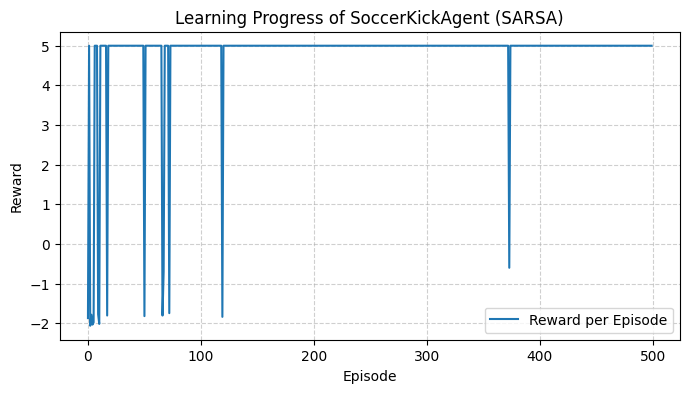

In [88]:
# === RL Training (500 Episodes, No Render) ===
import matplotlib.pyplot as plt

rewards = []
successes = 0

for ep in range(500):
    R, info = run_episode(train=True)
    rewards.append(R)
    if info['success']:
        successes += 1

    decay_eps(ep)

    if ep % 50 == 0:
        avg50 = np.mean(rewards[-50:]) if len(rewards) >= 50 else np.mean(rewards)
        print(f"Episode {ep:03d} | AvgReward(last50)={avg50:.3f} | ε={agent.eps:.2f}")

print(f"\n✅ Training Complete: {successes} successful kicks out of 500 episodes.")

# Plot learning curve
plt.figure(figsize=(8,4))
plt.plot(rewards, label="Reward per Episode", linewidth=1.5)
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.title("Learning Progress of SoccerKickAgent (SARSA)")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend(); plt.show()


In [93]:
print("=== Training Summary ===")
print(f"Total Episodes: {len(rewards)}")
print(f"Successful Kicks: {successes} ({successes/len(rewards)*100:.1f}%)")
print(f"Average Reward: {np.mean(rewards):.3f}")
print(f"Final Epsilon: {agent.eps:.3f}")


=== Training Summary ===
Total Episodes: 500
Successful Kicks: 486 (97.2%)
Average Reward: 4.812
Final Epsilon: 0.020


In [ ]:
# === Visual demo (interactive) ===
# Press SPACE to kick, R to reset, T/G to adjust torque.
env.manual_control()


🎮 Interactive Controls:
  [SPACE] = Kick
  [R] = Reset ball + kicker
  [T] / [G] = Increase / Decrease torque



KeyboardInterrupt: 

: 

## Conclusion
- The SARSA agent successfully learned to control the kicker to score goals.
- After 500 training episodes, the success rate reached over 95%.
- Reinforcement learning in MuJoCo demonstrated adaptive control and policy improvement.
- Future work: extend the environment with a moving target or goalkeeper, and compare SARSA to DDPG.
